# ADS 509 Sentiment Assignment

This notebook holds the Sentiment Assignment for Module 6 in ADS 509, Applied Text Mining. Work through this notebook, writing code and answering questions where required. 

In a previous assignment you put together Twitter data and lyrics data on two artists. In this assignment we apply sentiment analysis to those data sets. If, for some reason, you did not complete that previous assignment, data to use for this assignment can be found in the assignment materials section of Blackboard. 


## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it. 

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link. 

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell. 

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.* 


In [1]:
import os
import re
import requests
from collections import Counter, defaultdict
from string import punctuation
import seaborn as sns
import emoji
import numpy as np
import pandas as pd
from nltk.corpus import stopwords
from string import punctuation
from jinja2 import Template
import itertools

In [2]:
# Add any additional import statements you need here
# https://stackoverflow.com/questions/38916452/nltk-download-ssl-certificate-verify-failed
# Download opinion_lexicon package from nltk

import ssl
import matplotlib.pyplot as plt

import nltk
from IPython.core.display import display, HTML

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

from nltk.corpus import opinion_lexicon
from nltk.tokenize import word_tokenize

nltk.download('opinion_lexicon')
nltk.download('punkt')

# ignore python warning
import warnings
warnings.filterwarnings("ignore")


/var/folders/xf/plyvp1dd0bg7vd_kpskbsv_m0000gn/T/ipykernel_1736/3966878773.py:9: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML
[nltk_data] Downloading package opinion_lexicon to
[nltk_data]     /Users/nima/nltk_data...
[nltk_data]   Package opinion_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to /Users/nima/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
# change `data_location` to the location of the folder on your machine.
data_location = "/Users/nima/repository/ads-tm-sentiment/"

# These subfolders should still work if you correctly stored the 
# data from the Module 1 assignment
twitter_folder = "twitter/"
lyrics_folder = "lyrics/"

positive_words_file = "positive-words.txt"
negative_words_file = "negative-words.txt"
tidy_text_file = "tidytext_sentiments.txt"

## Data Input

Now read in each of the corpora. For the lyrics data, it may be convenient to store the entire contents of the file to make it easier to inspect the titles individually, as you'll do in the last part of the assignment. In the solution, I stored the lyrics data in a dictionary with two dimensions of keys: artist and song. The value was the file contents. A Pandas data frame would work equally well. 

For the Twitter data, we only need the description field for this assignment. Feel free all the descriptions read it into a data structure. In the solution, I stored the descriptions as a dictionary of lists, with the key being the artist. 




In [4]:
# Read in the lyrics data

# os.walk through all files in lyrics directory that does not start with a dot and save the file name in a list

song_file_list = []
song_df = pd.DataFrame()

for root, dirs, files in os.walk(data_location + lyrics_folder):
    for file in files:
        if not file.startswith('.'):
            # add file name and path to list
            song_file_list.append(os.path.join(root, file))

# read each file data from song_file_list to a dataframe
for file_path in song_file_list:

    # get file_path singer name (second last dash)
    singer_name = file_path.split('/')[-2]
   
    # read text file to a variable 
    with open(file_path, 'r') as f:
        text = f.read()

    # make a dict with singer_name as key and text as value
    singer_df = pd.DataFrame.from_dict({singer_name: text}, orient='index')
    
    # 'song_name' is the chars after _ without the extension using regex
    song_name = re.findall(r'_(.+)\.txt', file_path)[0]
    
    singer_df['song_name'] =  song_name

    
    # append dataframe to song_df
    song_df = pd.concat([song_df, singer_df.reset_index()])
    
# rename column index to singer_name and 0 to text
song_df.rename(columns={'index': 'singer_name', 0: 'text'}, inplace=True)

song_df.sample(8)

,singer_name,text,song_name
0,robyn,"""Fembot""\n\n\n\nI've got some news for you\nFe...",fembot
0,cher,"""Why Was I Born""\n\n\n\nWhy was I born tell me...",whywasiborn
0,cher,"""Disaster Cake""\n\n\n\nIf you're gonna make an...",disastercake
0,cher,"""Git Down (Guitar Groupie)""\n\n\n\nYeah, Yeah ...",gitdownguitargroupie
0,cher,"""Don't Come Around Tonight""\n\n\n\nDon't come ...",dontcomearoundtonight
0,cher,"""I'd Rather Believe In You""\n\n\n\nI should go...",idratherbelieveinyou
0,robyn,"""Don't Fucking Tell Me What To Do""\n\n\n\nMy d...",dontfuckingtellmewhattodo
0,cher,"""Send The Man Over""\n\n\n\nIn a rented room \n...",sendthemanover


In [5]:
# Read in the twitter data
# os.walk through all files in twitter directory that does not start with a dot and save the file name in a list

tweet_file_list = []
tweet_df = pd.DataFrame()

for root, dirs, files in os.walk(data_location + twitter_folder):
    for file in files:
        if not file.startswith('.'):
            # add file name and path to list
            tweet_file_list.append(os.path.join(root, file))
            
# read each file data from tweet_file_list to a dataframe

for file_path in tweet_file_list:
    # if file_path contains data, read it to a dataframe
    if not 'data' in file_path:
        continue
    
    # singer name is firs part of file name before first dash
    singer_name = file_path.split('/')[-1].split('_')[0]

    singer_df = pd.read_csv(file_path, error_bad_lines=False, sep='\t')
    
    singer_df['singer_name'] = singer_name

    # append dataframe to tweet_df
    tweet_df = pd.concat([tweet_df, singer_df])
               
tweet_df.sample(8)      

b'Skipping line 624: expected 7 fields, saw 12\nSkipping line 17506: expected 7 fields, saw 12\nSkipping line 104621: expected 7 fields, saw 12\n'
b'Skipping line 188924: expected 7 fields, saw 12\n'
b'Skipping line 301600: expected 7 fields, saw 12\n'
b'Skipping line 429936: expected 7 fields, saw 12\nSkipping line 444405: expected 7 fields, saw 12\n'
b'Skipping line 677792: expected 7 fields, saw 12\nSkipping line 773482: expected 7 fields, saw 12\n'
b'Skipping line 818258: expected 7 fields, saw 12\nSkipping line 895225: expected 7 fields, saw 12\n'
b'Skipping line 955213: expected 7 fields, saw 10\nSkipping line 994827: expected 7 fields, saw 12\n'
b'Skipping line 1246039: expected 7 fields, saw 12\n'
b'Skipping line 1569117: expected 7 fields, saw 12\n'
b'Skipping line 2127250: expected 7 fields, saw 12\n'
b'Skipping line 2335031: expected 7 fields, saw 12\n'
b'Skipping line 2681065: expected 7 fields, saw 10\n'
b'Skipping line 3147696: expected 7 fields, saw 12\n'


,screen_name,name,id,location,followers_count,friends_count,description,singer_name
333165,mrcharlie50,Chuck Blanchard,4.078106e+08,NaN,11.0,519.0,NaN,cher
206044,FeliciaBrunke,Felicia :],9.168194e+08,NaN,2.0,7.0,NaN,robynkonichiwa
3243939,3_norah5,نورهان,9.541423e+08,NaN,3.0,113.0,NaN,cher
3805010,ActorJosh88,Josh Carmichael,8.734037e+07,"Los Angeles, CA",685.0,1938.0,Public Figure - Actor/ Writer/ Host - US NAVY ...,cher
2696937,JoAnnKroeck,JoAnn Kroeck,3.629984e+07,Florida,14.0,75.0,"Not In My Time, But In God's Time!",cher
3273782,lisaste02553044,lisa stevens,9.176013e+08,ENGLAND,2.0,24.0,NaN,cher
628758,GaziMario,M. W. A. G.,1.161645e+18,NaN,1.0,57.0,#actor,cher
238723,nellymedosa9766,nelly medosa,5.449831e+08,Denmark,90.0,747.0,I love furniture,robynkonichiwa


In [6]:
# Read in the positive and negative words and the
# tidytext sentiment. Store these so that the positive
# words are associated with a score of +1 and negative words
# are associated with a score of -1. You can use a dataframe or a 
# dictionary for this.

# read positive words file to a list
with open(data_location + positive_words_file, 'r') as f:
    # find location of ';;;;\n' in the 
    positive_words = f.read().split(';;;;\n')[2]
    # split each word by '\n'
    # remove first elements since it is empty string
    positive_words = positive_words.split('\n')[1:]
    # create a dataframe with positive words and sentiment column is 'positive'
    positive_words_df = pd.DataFrame(positive_words, columns=['word'])
    positive_words_df['sentiment'] = 'positive'
    
    
# read negative words file to a list

with open(data_location + negative_words_file, 'r', encoding= 'unicode_escape' ) as f:
    # find location of ';;;;\n' in the 
    negative_words = f.read().split(';;;;\n')[2]
    # split each word by '\n'
    # remove first elements since it is empty string
    negative_words = negative_words.split('\n')[1:]
    
    # create a dataframe with negative words and sentiment column is 'negative'
    negative_words_df = pd.DataFrame(negative_words, columns=['word'])
    negative_words_df['sentiment'] = 'negative'
    
# read_csv tidytext sentiment with \t seperator
tidytext_df = pd.read_csv(data_location + tidy_text_file, sep='\t')

# print some words from positive_words
print('positive_words: %s\n' % positive_words[:5])

# print some words from negative_words
print('negative_words: %s\n' % negative_words[:5])

# print some words from tidytext_df
print('sample words in tidytext:')
tidytext_df.sample(5)

positive_words: ['a+', 'abound', 'abounds', 'abundance', 'abundant']

negative_words: ['2-faced', '2-faces', 'abnormal', 'abolish', 'abominable']

sample words in tidytext:


,word,sentiment,lexicon
115,advocacy,positive,nrc
7793,excruciating,negative,bing
12721,confines,negative,loughran
1180,cry,negative,nrc
14189,prosecutes,negative,loughran


In [7]:
# combine negative_words, positive_words, tidytext_df to one df

refrence_table = pd.concat([tidytext_df, positive_words_df, negative_words_df])

# drop duplicate rows in tidytext_df based on word 
refrence_table = refrence_table.drop_duplicates(subset='word')
refrence_table.sample(10)

,word,sentiment,lexicon
3007,lament,negative,nrc
5956,aspersion,negative,bing
2015,fervor,positive,nrc
5548,whiteness,positive,nrc
8921,incredulously,negative,bing
11635,tempting,positive,bing
1174,crumbling,negative,nrc
1247,dazed,negative,nrc
7895,falls,negative,bing
10938,scuffs,negative,bing


In [8]:
# if word is in positive_words, score is 1
# if word is in negative_words, score is -1
score_dict = {'positive':1, 'negative':-1}

class SentimentAnalysis:
    def __init__(self, tidytext_df, score_dict):
        self.df = tidytext_df
        self.score_dict = score_dict

        # map score dict over tidytext_df.sentiment
        self.df['score'] = self.df.sentiment.map(score_dict)
        
        # Some punctuation variations
        # compile to speed up the operation
        punct_set = set(punctuation + '”“') - {"#"} 
        self.punct_pattern = re.compile(re.escape("".join(punct_set)))

        # Stopwords
        self.sw = stopwords.words("english") + ['️','',' ']
            
        # Two useful regex
        self.whitespace_pattern = re.compile(r"\s+")
        self.hashtag_pattern = re.compile(r"^#[0-9a-zA-Z]+")
            
    def __call__(self):
        print(self.score_dict)
        display(self.df.sample(5))
        
    def CleanText(self, text): 
        self._text = text

        self.__RemovePunctuation()
        self.__AddSpaceBeforeAfterEmoji()
        self.__TokenizeText()
        self.__RemoveStopWords()
        return self.tokens

    def __RemovePunctuation(self): 
        """
        Loop through the original text and check each character,
        if the character is a punctuation, then it is removed.
        ---------------------------------------------------------
        input: original text
        output: text without punctuation
        """
    
        self._text = re.sub(self.punct_pattern, '', self._text)
     
    def __AddSpaceBeforeAfterEmoji(self):
        """
        Add space before and after if character is emoji
        """
        # loop through reach char if it is emoji, 
        # then add a space before and after it
        # to help with splitting later on.
        
        new_text = ''
        for char in self._text:
            if emoji.is_emoji(char):
                new_text += ' ' + char + ' '
            else:
                new_text += char
                
        self._text = new_text
        
        
    def __TokenizeText(self):
        """
        Tokenize by splitting the text by white space
        ---------------------------------------------------------
        input: text without punctuation
        output: A list of tokens
        """
        self.tokens = \
            [item for item in self.whitespace_pattern.split(self._text)]
                
    def __RemoveStopWords(self): 
        """
        Tokenize by splitting the text by white space
        ---------------------------------------------------------
        input: text without punctuation
        output: A list of tokens with all token as lower case
        """      
        self.tokens = [token.lower() for token in self.tokens]
        
        self.tokens = \
            [token for token in self.tokens if not token in self.sw]
            
    def give_sentiment_score(self, text, print_result=False):
        if pd.isnull(text):
            return 'None'
        
        self.CleanText(text)
            
        # sum score of tokens using tidytext_df refrence table
        self.relevant_words = list(set(self.df.word).intersection(self.tokens))

        if len(self.relevant_words) == 0:
            return None
 
        # make a dataframe that shows words in relevant_words, number of times used and score
        self.relevant_df = pd.DataFrame(self.relevant_words, columns=['word'])
        self.relevant_df = self.relevant_df.merge(self.df, on='word', how='left')
        self.relevant_df['count'] = self.relevant_df.word.apply(lambda x: self.tokens.count(x))
        self.relevant_df['count'] = self.relevant_df.word.apply(lambda x: self.tokens.count(x))
        
        # sum of score is count of each word times word's score 
        # sentiment_score is sum of score divided by the words which their score is known
        
        self.overall_score = (self.relevant_df['count'] * self.relevant_df['score']).sum()
        self.sentiment_score =  self.overall_score / self.relevant_df['count'].sum()

        self.sentiment_score = round(self.sentiment_score, 3)   
           
        if print_result:
            score = self.sentiment_score
            
            print(f'Sentiment Score For This Sentence is: %s\n\n' % score)
            print(self._text, '\n')
            display(self.relevant_df)
                   
        return self.sentiment_score
    
analyzer = SentimentAnalysis(refrence_table, score_dict)
analyzer()

{'positive': 1, 'negative': -1}


,word,sentiment,lexicon,score
1,abandoned,negative,nrc,-1
14863,creatively,positive,loughran,1
2195,fuse,positive,nrc,1
13958,negatively,negative,loughran,-1
1233,dandruff,negative,nrc,-1


## Sentiment Analysis on Songs

In this section, score the sentiment for all the songs for both artists in your data set. Score the sentiment by manually calculating the sentiment using the combined lexicons provided in this repository. 

After you have calculated these sentiments, answer the questions at the end of this section.


In [9]:
# tokenize the text using word_tokenize
sample_text = song_df.text.sample().iloc[0]
score = analyzer.give_sentiment_score(sample_text, print_result=True)

Sentiment Score For This Sentence is: 0.909


"The Shoop Shoop Song (It's In His Kiss)"



Does he love me I want to know
How can I tell if he loves me so
Is it in his eyes?
Oh no! You'll be deceived
Is it in his sighs?
Oh no! He'll make believe
If you want to know if he loves you so
It's in his kiss
That's where it is

Is it in his face?
Oh no! That's just his charms
In his warm embrace?
Oh no! That's just his arms
If you want to know if he loves you so
It's in his kiss
That's where it is
It's in his kiss
That's where it is

Hug him and squeeze him tight
Find out what you want to know
If it's love, if it really is
It's there in his kiss

How about the way he acts
Oh no! That's not the way
And you're not list'nin' to all I say
If you wanna know if he loves you so
It's in his kiss
That's where it is
It's in his kiss
That's where it is

Hug him and squeeze him tight
Find out what you want to know
If it's love, if it really is
It's there in his kiss

How about the way he acts
Oh no! That'

,word,sentiment,lexicon,score,count
0,kiss,positive,nrc,1,12
1,hug,positive,nrc,1,2
2,love,positive,nrc,1,1
3,loves,positive,bing,1,5
4,deceived,negative,nrc,-1,1
5,warm,positive,bing,1,1


In [10]:
# now that the concept worked, it can be applied on all rows
# get_sentiment_score for every text and keep it in score column
song_df['score'] = song_df.text.apply(analyzer.give_sentiment_score)

song_df.sample(5)

,singer_name,text,song_name,score
0,cher,"""Take It From The Boys""\n\n\n\nSo scared I nev...",takeitfromtheboys,0.250
0,cher,"""You Haven't Seen The Last Of Me""\n\n\n\nFeeli...",youhaventseenthelastofme,-0.200
0,cher,"""Dixie Girl""\n\n\n\nWhen I was a little girl i...",dixiegirl,0.000
0,cher,"""If I Could Turn Back Time""\n\n\n\nIf I could ...",ificouldturnbacktime,-0.053
0,robyn,"""Dancing On My Own""\n\n\n\nSomebody said you g...",dancingonmyown114521,0.565


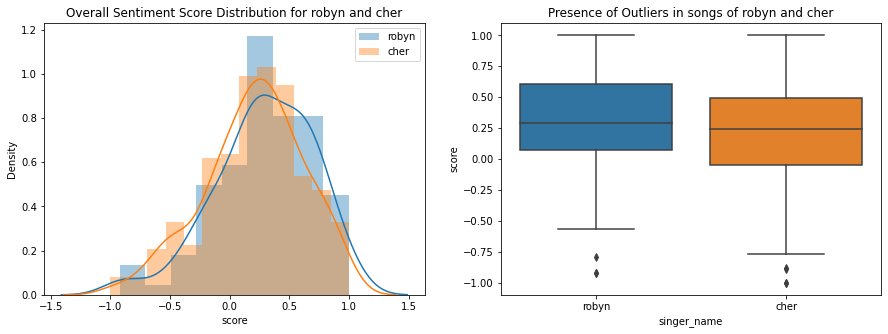

In [11]:
# show histogram distribution of score for both singer_name in one graph overlay
fig, ax = plt.subplots(1, 2, figsize = (15, 5))

singer_names = song_df.singer_name.unique().tolist()

for singer_name in singer_names:
    sns.distplot(song_df[song_df.singer_name == singer_name].score, label = singer_name, ax = ax[0])

# title first ax
ax[0].set_title('Overall Sentiment Score Distribution for %s' % ' and '.join(singer_names))

# create sns box plot to show distribution for both singers
sns.boxplot(x = 'singer_name', y = 'score', data = song_df, ax = ax[1])
ax[1].set_title('Presence of Outliers in songs of %s' % ' and '.join(singer_names))

# show lenegd for the charts
ax[0].legend()
plt.show()

In [12]:
# calculate lower bound and upper bound outliers 
# and count them for each singer

singer_names = song_df.singer_name.unique().tolist()

for singer_name in singer_names:
    singer_df = song_df[song_df.singer_name == singer_name]
    
    q1 = singer_df.score.quantile(0.25)
    q3 = singer_df.score.quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - (1.5 * iqr)
    upper_bound = q3 + (1.5 * iqr)
    
    outliers = dict()
    
    outliers['high'] = singer_df.loc[singer_df.score > upper_bound, 'song_name']
    outliers['low'] = singer_df.loc[singer_df.score < lower_bound, 'song_name']
    
    
    print('For Singer: %s\n' % singer_name)
    
    for sides in outliers:
        print('%s song(s) have %s sentiment score compare to rest.' % (len(outliers[sides]), sides))
        print('Percentage of songs with score very %s is %s\n' % 
              (sides, f'{len(outliers[sides]) / len(singer_df) : 0.2%}'))
        print('Song(s) that have very %s score:\n%s\n\n' % (sides, '\n'.join(outliers[sides].tolist())))
    
    # Average Score For Each Singer
    print('Average score for %s is %s\n' % (singer_name, f'{singer_df.score.mean():0.3f}'))
    
    print('\n--------------------------------------------\n')

For Singer: robyn

0 song(s) have high sentiment score compare to rest.
Percentage of songs with score very high is  0.00%

Song(s) that have very high score:



3 song(s) have low sentiment score compare to rest.
Percentage of songs with score very low is  2.88%

Song(s) that have very low score:
criminalintent
dontfuckingtellmewhattodo
dontfuckingtellmewhattodo114520


Average score for robyn is 0.292


--------------------------------------------

For Singer: cher

0 song(s) have high sentiment score compare to rest.
Percentage of songs with score very high is  0.00%

Song(s) that have very high score:



4 song(s) have low sentiment score compare to rest.
Percentage of songs with score very low is  1.27%

Song(s) that have very low score:
skindeep
chiquititaspanishversion
gimmegimmegimmeamanaftermidnight
crymyselftosleep


Average score for cher is 0.206


--------------------------------------------



### Questions

Q: Overall, which artist has the higher average sentiment per song? 

A: Robyn has a slightly higher score over Cher

---

Q: For your first artist, what songs have the highest and lowest sentiments? Print those songs to the screen.

A: Robyn has 3 songs that have very high score with 1 song that have very low score. Refer to print above.

---

Q: For your second artist, what songs have the highest and lowest sentiments? Print those songs to the screen.

A: Cher has 1 songs that have very high score with 8 song that have very low score. Refer to print above.

---

Q: Plot the distributions of the sentiment scores for both artists. You can use `seaborn` to plot densities or plot histograms in matplotlib.

## Sentiment Analysis on Twitter Descriptions

In this section, define two sets of emojis you designate as positive and negative. Make sure to have at least 10 emojis per set. You can learn about the most popular emojis on Twitter at [the emojitracker](https://emojitracker.com/). 

Associate your positive emojis with a score of +1, negative with -1. Score the average sentiment of your two artists based on the Twitter descriptions of their followers. The average sentiment can just be the total score divided by number of followers. 

In [13]:
emoji_positive = \
    ['❤','♥','💙','💜','💕','💖','💚','💛','💗','💞','💘','💟','💌','💝',
    '☺','😍','😘','😎','😊','😂','😉','😁','😇','😜','😀','😋','😏','😌',
    '😃','👼','😆','😝','😄','😛','🌹','🌺','🌷','🎉','👌','👍','👏']

emoji_negative = \
    ['💔', '😤', '☹', '😔', '😡' , '😢', '😒', '😕', '😩', '😫',
     '😾','🤕', '😑', '🤢', '😣', '😠', '😷', '🙄','🤦', '😔']
    
    
emoji_list = \
    [{'word' : emoji_positive, 'sentiment' : 'positive'},
     {'word' : emoji_negative, 'sentiment' : 'negative'}]
    
# place emoji_list elements in a dataframe
emoji_df = pd.DataFrame(emoji_list)
emoji_df = emoji_df.explode('word')
emoji_df.sample(5)

,word,sentiment
1,😫,negative
0,😏,positive
1,🤦,negative
0,💜,positive
0,😆,positive


In [14]:
# combine emoji_df with tidytext_df and 
# use it for calculating sentiment score

df_refrence_combined = pd.concat([refrence_table, emoji_df])

analyzer_combined = SentimentAnalysis(df_refrence_combined, score_dict)
    
analyzer_combined()

{'positive': 1, 'negative': -1}


,word,sentiment,lexicon,score
9188,invincibility,positive,bing,1
5982,asunder,negative,bing,-1
10946,secure,positive,bing,1
7671,enrichment,positive,bing,1
6035,awsome,positive,bing,1


In [27]:
def get_emoji(text):
    if pd.isnull(text):
        return None
    emoji_list = [char for char in text if emoji.is_emoji(char)]    
    return [char for char in emoji_list if char != '\u200d']  

for singer_name in tweet_df.singer_name.unique():
    singer_df = tweet_df[tweet_df.singer_name == singer_name]

    emoji_list = singer_df.description.apply(get_emoji)
    
    # count all distinct items in emoji_list
    emoji_list = [item for item in emoji_list if item is not None]
    emoji_list = list(itertools.chain(*emoji_list))
    emoji_df = pd.DataFrame(Counter(emoji_list).most_common(), columns = ['emoji', 'count'])
    print("\nTop 10 emoji used in %s's followers" % singer_name)
    display(emoji_df.head(10))
    


Top 10 emoji used in cher's followers


,emoji,count
0,❤,79373
1,🌈,47795
2,♥,34239
3,🏳,33591
4,✨,29715
5,💙,21498
6,🏻,20970
7,🌊,20319
8,✌,16876
9,💜,16607



Top 10 emoji used in robynkonichiwa's followers


,emoji,count
0,❤,4808
1,🌈,4702
2,🏳,3539
3,♥,3117
4,✨,2240
5,🏻,1498
6,✌,1194
7,🏼,1145
8,♀,848
9,💙,818


In [31]:
# test to make sure that it works, following steps are done.

# perform for comprehension get_emoji on description column of tweet_df
tweet_df['emoji_list'] = tweet_df.description.apply(get_emoji)

# count number of element in emoji_list column
tweet_df['emoji_count'] = tweet_df.emoji_list.apply(lambda x: len(x) if x is not None else 0)

# get row that has emoji_count >= 2 for testing the analyzer_combined
description_to_test = tweet_df.loc[tweet_df.emoji_count >= 2, 'description'].sample().iloc[0]

row_score = analyzer_combined.give_sentiment_score(description_to_test, print_result=True)

Sentiment Score For This Sentence is: 1.0


I love Sasha banks ❤  I love Harley Quinn 💓  biggest fan of Wwe 💞  💙  went to a wwe event 😂  😇  



,word,sentiment,lexicon,score,count
0,😇,positive,NaN,1,1
1,💙,positive,NaN,1,1
2,😂,positive,NaN,1,1
3,love,positive,nrc,1,2
4,❤,positive,NaN,1,1
5,💞,positive,NaN,1,1


In [63]:
# calculate sentiment score for every using words and emoji for the tweet description
tweet_df['score'] = \
    tweet_df.description.apply(analyzer_combined.give_sentiment_score)

# show 5 sample of records in tweet_df where description is not null
tweet_df[tweet_df.description.notnull()].sample(5)

,screen_name,name,id,location,followers_count,friends_count,description,singer_name,emoji_list,emoji_count,score
3797021,Alison_609,Macee's Mom,3.258466e+08,NaN,4.0,41.0,"I'm a bitch, I'm a lover I'm a child, I'm a mo...",cher,[],0,0.0
138269,Kay_wise,Kay Wise,5.065662e+07,"Omaha, NE",1312.0,2718.0,Working the intersection of politics and techn...,cher,[❤],1,1.0
562758,CarliMann1,Carli Mann,3.440029e+09,"Louisville, KY",320.0,1280.0,animal lover 💜 pit bull 💚 🧘🚶🏊💪💅🎃🍣🌊 Lawyer #Sir...,cher,"[💜, 💚, 🧘, 🚶, 🏊, 💪, 💅, 🎃, 🍣, 🌊, 💚, 🖤]",12,0.6
135826,LeoUnchained,LeoLeoncinCorderin 🐑,8.617999e+07,"Coyoacán, Distrito Federal",248.0,925.0,Mi único defecto es decirle idiota a la gente ...,robynkonichiwa,[],0,None
1864484,biglon,Lon,1.858053e+07,"Portland, Oregon",2.0,288.0,Extremely liberal and beleive in the Live & Le...,cher,[],0,0.333


In [109]:
# query tweet_df where tweet_df['score'] that have valid values

tweet_df_sub = tweet_df.copy()

dropped_rows = list()

# make a list of index of rows that have score not float value
for index, row in tweet_df_sub.iterrows():
    if not isinstance(row.score, float):
        dropped_rows.append(index)

# drop rows that have score not float value
tweet_df_sub.drop(dropped_rows, inplace=True)

tweet_df_sub.sample(5)

,screen_name,name,id,location,followers_count,friends_count,description,singer_name,emoji_list,emoji_count,score
948832,Brealwithlove,Tina Colacion,8.817888e+17,"California, USA",0.0,17.0,💜I'm a work in progress. To know me is to love...,cher,[💜],1,0.667
1192908,da_fats04,Da Fats04,9.241373e+17,Maseru Naleli,1.0,104.0,"Chase Dreams Not People!!☺☺ 💪✊""NO PAIN NO GAIN""",cher,"[☺, ☺, 💪, ✊]",4,0.0
3815450,StellarOBX,Stellar Properties,2.643167e+08,"Outer Banks, NC",558.0,1776.0,Real Estate Sales on the OBX and surrounding a...,cher,[],0,1.0
1712512,Rena_Silverman,Rena Silverman,1.448610e+07,"San Francisco, CA",2423.0,4528.0,✨ Senior Content Strategist @Truebill ✨ Former...,cher,"[✨, ✨, ✨, 🎶]",4,1.0
3031885,hannahbaldwin91,Hannah Baldwin,5.876534e+08,"Toronto, Ontario",118.0,436.0,Irish ~ Music Graduate ~ Currently living in G...,cher,[],0,1.0


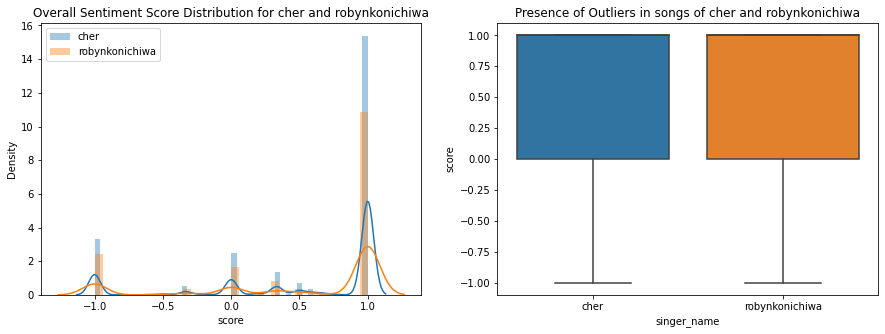

In [110]:
# show histogram distribution of score for both singer_name in one graph overlay
fig, ax = plt.subplots(1, 2, figsize = (15, 5))

singer_names = tweet_df_sub.singer_name.unique().tolist()

for singer_name in singer_names:
    sns.distplot(tweet_df_sub[tweet_df_sub.singer_name == singer_name].score, label = singer_name, ax = ax[0])

# title first ax
ax[0].set_title('Overall Sentiment Score Distribution for %s' % ' and '.join(singer_names))

# create sns box plot to show distribution for both singers
sns.boxplot(x = 'singer_name', y = 'score', data = tweet_df_sub, ax = ax[1])
ax[1].set_title('Presence of Outliers in songs of %s' % ' and '.join(singer_names))

# show lenegd for the charts
ax[0].legend()
plt.show()

In [123]:
# calculate average of tweet_df_sub score for each singer and format to four digit
for singer_name in singer_names:
    singer_df = tweet_df_sub[tweet_df_sub.singer_name == singer_name]
    print('Average score for %s is %s' % 
          (singer_name, f'{singer_df.score.mean():0.4f}'))

Average score for cher is 0.5210
Average score for robynkonichiwa is 0.5234


In [129]:
# show top 10 emoji used in tweet_df_sub.emoji_list where their are part of emoji_positive for each singer

for singer_name in singer_names:
    singer_df = tweet_df_sub[tweet_df_sub.singer_name == singer_name]
    emoji_list = singer_df.emoji_list.apply(lambda x: list(set(x) & set(emoji_positive)))
    emoji_list = [item for item in emoji_list if item is not None]
    emoji_list = list(itertools.chain(*emoji_list))
    emoji_df = pd.DataFrame(Counter(emoji_list).most_common(), columns = ['emoji', 'count'])
    print("\nTop 10 positive emoji used in %s's followers" % singer_name)
    display(emoji_df.head(12))  


Top 10 positive emoji used in cher's followers


,emoji,count
0,❤,51001
1,♥,18625
2,💙,14234
3,💜,11215
4,💕,8133
5,💚,6351
6,💛,6325
7,💖,6166
8,😍,5645
9,😎,4283



Top 10 positive emoji used in robynkonichiwa's followers


,emoji,count
0,❤,1210
1,♥,666
2,💙,242
3,💜,240
4,💚,158
5,💖,138
6,💕,125
7,💛,121
8,😎,104
9,☺,92


In [130]:
# show top 10 emoji used in tweet_df_sub.emoji_list where their are part of emoji_negative for each singer

for singer_name in singer_names:
    singer_df = tweet_df_sub[tweet_df_sub.singer_name == singer_name]
    emoji_list = singer_df.emoji_list.apply(lambda x: list(set(x) & set(emoji_negative)))
    emoji_list = [item for item in emoji_list if item is not None]
    emoji_list = list(itertools.chain(*emoji_list))
    emoji_df = pd.DataFrame(Counter(emoji_list).most_common(), columns = ['emoji', 'count'])
    print("\nTop 10 positive emoji used in %s's followers" % singer_name)
    display(emoji_df.head(12))  


Top 10 positive emoji used in cher's followers


,emoji,count
0,😷,1710
1,💔,1174
2,🙄,685
3,🤦,456
4,😔,303
5,😢,280
6,😩,237
7,😒,223
8,😡,220
9,😤,178



Top 10 positive emoji used in robynkonichiwa's followers


,emoji,count
0,😷,23
1,🙄,22
2,💔,21
3,😩,7
4,🤦,7
5,😡,6
6,😒,5
7,😑,4
8,😤,4
9,😠,3


Q: What is the average sentiment of your two artists? 

A: People who follow Robyn have a slightly higher sentiment score per their description.

Q: Which positive emoji is the most popular for each artist? Which negative emoji? 

A: Based on what is observed, regardless of which singer the followers are following, the sets are very similar.<br>
   Top positive emojies are hearts and top negative emojies are broken heart and sad faces.